In [2]:
from os.path import basename, exists
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import numpy as np
import json
from matplotlib.colors import ListedColormap

In [3]:
# Load the data from MITRE ATT&CK softwares (https://attack.mitre.org/software/)
with open('software_techniques.json') as f:
    software_techniques = json.load(f)

In [4]:

# Load the data from the tactics json file
with open('tactics_techniques.json') as f:
    tactics_data = json.load(f)

# TODO: fix one to many mapping
# Convert tactics data to a dictionary
tactics_dict = {}
step = 0 # The step of the tactic. Used to sort techniques later.
for item in tactics_data:
    for technique in item["techniques"]:
        tactics_dict[technique["id"]] = (step, item["tactic"])
    step += 1

In [5]:
# Maps to store nodes of each tactic
tactics = {
    'Initial Access': set(),
    'Execution': set(),
    'Persistence': set(),
    'Privilege Escalation': set(),
    'Defense Evasion': set(),
    'Credential Access': set(),
    'Discovery': set(),
    'Lateral Movement': set(),
    'Collection': set(),
    'Command and Control': set(),
    'Exfiltration': set(),
    'Impact': set(),
}

colors = ['red', 'orange', 'yellow', 'lightgreen', 'green', 'lightblue', 'blue', 'purple', 'violet', 'brown', 'pink', 'grey']

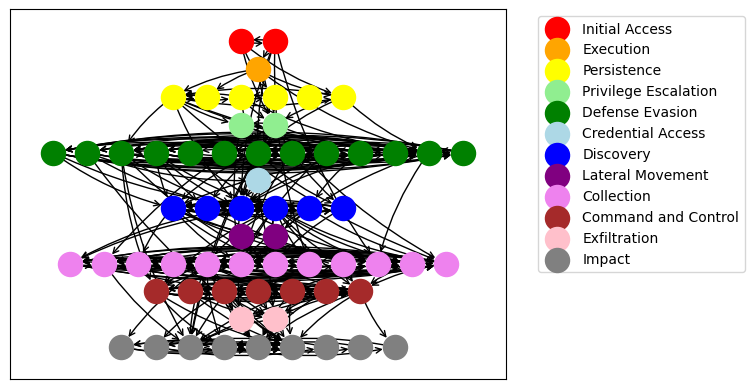

In [6]:
from queue import PriorityQueue


G = nx.DiGraph()

pos = {}

for software in software_techniques:
    software_techniques_pq = PriorityQueue()
    for technique in software["techniques"]:
        technique_id = technique["technique_id"]
        step = tactics_dict.get(technique_id)[0]
        software_techniques_pq.put((step, technique_id))

    prev_technique_id = None
    prev_step = None
    
    while not software_techniques_pq.empty():
        technique = software_techniques_pq.get()
        step = technique[0]
        technique_id = technique[1]
        tactic = tactics_dict.get(technique_id)[1]
        if tactic:
            G.add_node(technique_id, tactic=tactic)
            tactics[tactic].add(technique_id)
        if prev_technique_id is not None and technique_id != prev_technique_id:
            G.add_edge(prev_technique_id, technique_id)
            if prev_step is not None and prev_step == step:
                G.add_edge(technique_id, prev_technique_id)
        prev_step = step
        prev_technique_id = technique_id

# Calculate the number of techniques in each tactic
tactic_counts = {tactic: len(nodes) for tactic, nodes in tactics.items()}

# Calculate the spacing between nodes within each tactic
spacing = 1 / max(tactic_counts.values())

# Set the initial y-position for each tactic
y_positions = {tactic: -i for i, tactic in enumerate(tactics.keys())}

# used for centering
max_count = max(tactic_counts.values())

# Set the positions for the nodes within each tactic
for tactic, nodes in tactics.items():
    y = y_positions[tactic]
    for i, node in enumerate(nodes):
        # center graph
        x = i * spacing + max_count - tactic_counts[tactic] * spacing / 2
        pos[node] = (x, y)

# Draw the nodes and edges
for tactic, color in zip(tactics.keys(), colors):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=tactics[tactic], node_color=color, label=tactic)
nx.draw_networkx_edges(G, pos=pos, arrows=True, arrowstyle='->', connectionstyle='arc3,rad=0.1')  # Set arrows=True, arrowstyle='->', and connectionstyle='arc3,rad=0.1'

# Add labels for the nodes
# labels = {node: node for node in G.nodes()}
# nx.draw_networkx_labels(G, pos=pos, labels=labels)

# Adjust the position of the legend
plt.legend(scatterpoints=1, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('figs/degree_centrality/attack_paths_network_graph.png', dpi=300, bbox_inches='tight')

plt.show()

In [7]:
degree_centrality = nx.degree_centrality(G)
degree_centrality

{'T1623': 0.0967741935483871,
 'T1404': 0.22580645161290322,
 'T1626': 0.0967741935483871,
 'T1406': 0.46774193548387094,
 'T1407': 0.45161290322580644,
 'T1629': 0.24193548387096775,
 'T1633': 0.1935483870967742,
 'T1418': 0.3870967741935484,
 'T1422': 0.3225806451612903,
 'T1426': 0.4032258064516129,
 'T1429': 0.3225806451612903,
 'T1430': 0.3225806451612903,
 'T1512': 0.24193548387096775,
 'T1517': 0.1774193548387097,
 'T1533': 0.3064516129032258,
 'T1636': 0.5161290322580645,
 'T1437': 0.3870967741935484,
 'T1544': 0.1935483870967742,
 'T1646': 0.16129032258064516,
 'T1474': 0.11290322580645161,
 'T1577': 0.06451612903225806,
 'T1628': 0.3387096774193548,
 'T1630': 0.29032258064516125,
 'T1424': 0.16129032258064516,
 'T1643': 0.2096774193548387,
 'T1624': 0.2096774193548387,
 'T1644': 0.25806451612903225,
 'T1481': 0.22580645161290322,
 'T1417': 0.4032258064516129,
 'T1513': 0.27419354838709675,
 'T1532': 0.1935483870967742,
 'T1471': 0.16129032258064516,
 'T1582': 0.30645161290322

In [8]:
# Create a dictionary to map IDs to names
id_to_name = {}
for tactic in tactics_data:
    for technique in tactic['techniques']:
        id_to_name[technique['id']] = technique['name']

# Create a new dictionary with names as keys
degree_centrality_names = {}
for id, centrality in degree_centrality.items():
    name = id_to_name.get(id, id)  # If the ID is not found in the mapping, use the ID itself
    degree_centrality_names[name] = centrality

In [9]:
for name, centrality in degree_centrality_names.items():
    print(f"{name}: {centrality}")

Command and Scripting Interpreter: 0.0967741935483871
Exploitation for Privilege Escalation: 0.22580645161290322
Abuse Elevation Control Mechanism: 0.0967741935483871
Obfuscated Files or Information: 0.46774193548387094
Download New Code at Runtime: 0.45161290322580644
Impair Defenses: 0.24193548387096775
Virtualization/Sandbox Evasion: 0.1935483870967742
Software Discovery: 0.3870967741935484
System Network Configuration Discovery: 0.3225806451612903
System Information Discovery: 0.4032258064516129
Audio Capture: 0.3225806451612903
Location Tracking: 0.3225806451612903
Video Capture: 0.24193548387096775
Access Notifications: 0.1774193548387097
Data from Local System: 0.3064516129032258
Protected User Data: 0.5161290322580645
Application Layer Protocol: 0.3870967741935484
Ingress Tool Transfer: 0.1935483870967742
Exfiltration Over C2 Channel: 0.16129032258064516
Supply Chain Compromise: 0.11290322580645161
Compromise Application Executable: 0.06451612903225806
Hide Artifacts: 0.3387096

In [10]:
# Find the minimum and maximum centrality scores
min_score = min(degree_centrality_names.values())
max_score = max(degree_centrality_names.values())

# Perform min-max normalization on the centrality scores
normalized_scores = {}
for name, centrality in degree_centrality_names.items():
    normalized_score = (centrality - min_score) / (max_score - min_score)
    normalized_scores[name] = normalized_score

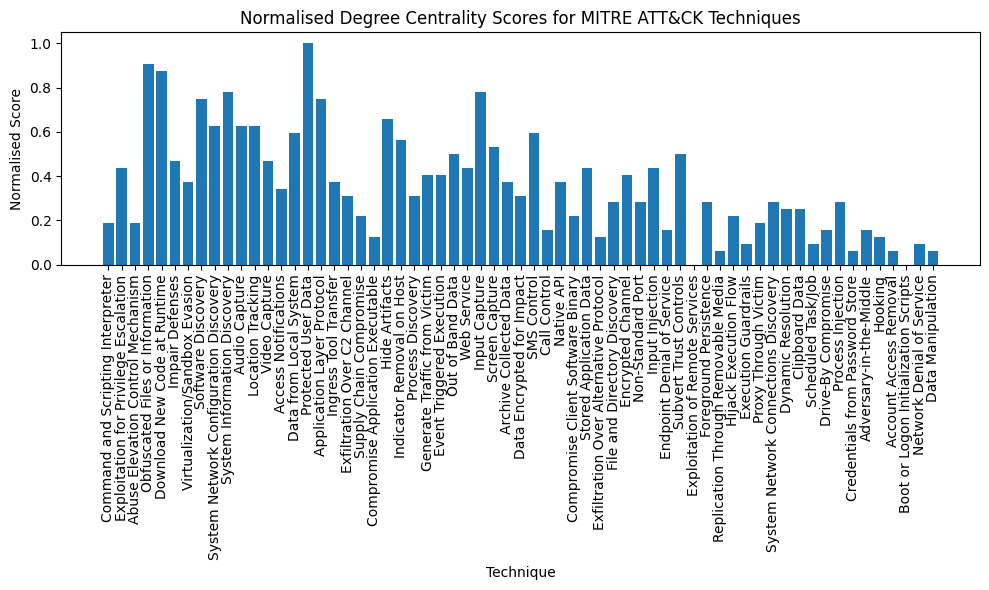

In [11]:
# Prepare the data for plotting
names = list(normalized_scores.keys())
scores = list(normalized_scores.values())

# Plot the normalized scores
plt.figure(figsize=(10, 6))
plt.bar(names, scores)
plt.xlabel('Technique')
plt.ylabel('Normalised Score')
plt.title('Normalised Degree Centrality Scores for MITRE ATT&CK Techniques')
plt.xticks(rotation=90)
plt.tight_layout()

plt.savefig('figs/degree_centrality/techniques_degree_centrality_normalised.png', dpi=300, bbox_inches='tight')

plt.show()

In [12]:
import requests
from bs4 import BeautifulSoup
import time

base_url = "https://attack.mitre.org"

def get_mitigations(url):
    mitigations = {}

    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # find and loop through each row in the table
    for row in soup.find_all('tr'):
        cells = row.find_all('td')
        if len(cells) > 1:
            mitigation_name = cells[1].text.strip()
            mitigation_link = cells[0].find('a')['href']

            techniques = get_techniques(base_url + mitigation_link)

            # Add the set of techniques to the dictionary
            mitigations[mitigation_name] = techniques

            # Avoid making requests too quickly
            time.sleep(1)

    return mitigations

def get_techniques(url):
    techniques = set()

    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # find and loop through each row in the techniques addressed table
    techniques_table = soup.find("table", class_="table techniques-used background table-bordered")
    if techniques_table:
        for row in techniques_table.find_all('tr', class_='technique mobile'):
            cells = row.find_all('td')
            if len(cells) > 1:
                technique_name = cells[-2].text.strip() 
                techniques.add(technique_name)

    return techniques

# Scrape the data
mitigations = get_mitigations("https://attack.mitre.org/mitigations/mobile/")

# Print the data
print(mitigations)


{'Application Developer Guidance': {'Screen Capture', 'Access Notifications', 'Steal Application Access Token', 'Abuse Elevation Control Mechanism', 'Supply Chain Compromise'}, 'Attestation': {'Hijack Execution Flow', 'Boot or Logon Initialization Scripts', 'Hooking', 'Indicator Removal on Host', 'Exploitation for Privilege Escalation', 'Credentials from Password Store', 'Process Discovery', 'Compromise Client Software Binary', 'Command and Scripting Interpreter'}, 'Deploy Compromised Device Detection Method': {'Hooking', 'Exploitation for Privilege Escalation', 'Credentials from Password Store', 'Command and Scripting Interpreter', 'Impair Defenses'}, 'Encrypt Network Traffic': {'Adversary-in-the-Middle'}, 'Enterprise Policy': {'Screen Capture', 'Replication Through Removable Media', 'Access Notifications', 'Subvert Trust Controls', 'Input Injection', 'Location Tracking', 'Input Capture', 'Lockscreen Bypass', 'Exploitation of Remote Services', 'Impair Defenses'}, 'Interconnection Filt

In [13]:
mitigation_degree_centrality = {}
for mitigation, techniques in mitigations.items():
    degree_centrality_sum = 0
    for technique in techniques:
        degree_centrality = degree_centrality_names.get(technique, 0)
        degree_centrality_sum += degree_centrality
    mitigation_degree_centrality[mitigation] = degree_centrality_sum
    
for mitigation, centrality in mitigation_degree_centrality.items():
    print(f"{mitigation}: {centrality}")

Application Developer Guidance: 0.6612903225806451
Attestation: 1.096774193548387
Deploy Compromised Device Detection Method: 0.6612903225806451
Encrypt Network Traffic: 0.08064516129032258
Enterprise Policy: 1.9354838709677418
Interconnection Filtering: 0.3225806451612903
Lock Bootloader: 0.14516129032258063
Security Updates: 1.193548387096774
System Partition Integrity: 0.467741935483871
Use Recent OS Version: 4.435483870967742
User Guidance: 4.612903225806452


In [14]:
# Normalise the data 
min_value = min(mitigation_degree_centrality.values())
max_value = max(mitigation_degree_centrality.values())

normalised_mit_degree = {key: (value - min_value) / (max_value - min_value) for key, value in mitigation_degree_centrality.items()}

print("--Normalised mitigation degree centrality--")
for key, value in normalised_mit_degree.items():
    print(f"{key}: {value}")

--Normalised mitigation degree centrality--
Application Developer Guidance: 0.1281138790035587
Attestation: 0.22419928825622776
Deploy Compromised Device Detection Method: 0.1281138790035587
Encrypt Network Traffic: 0.0
Enterprise Policy: 0.40925266903914587
Interconnection Filtering: 0.05338078291814947
Lock Bootloader: 0.014234875444839853
Security Updates: 0.24555160142348753
System Partition Integrity: 0.08540925266903916
Use Recent OS Version: 0.9608540925266903
User Guidance: 1.0


{'Application Developer Guidance': 0.1281138790035587, 'Attestation': 0.22419928825622776, 'Deploy Compromised Device Detection Method': 0.1281138790035587, 'Encrypt Network Traffic': 0.0, 'Enterprise Policy': 0.40925266903914587, 'Interconnection Filtering': 0.05338078291814947, 'Lock Bootloader': 0.014234875444839853, 'Security Updates': 0.24555160142348753, 'System Partition Integrity': 0.08540925266903916, 'Use Recent OS Version': 0.9608540925266903, 'User Guidance': 1.0}


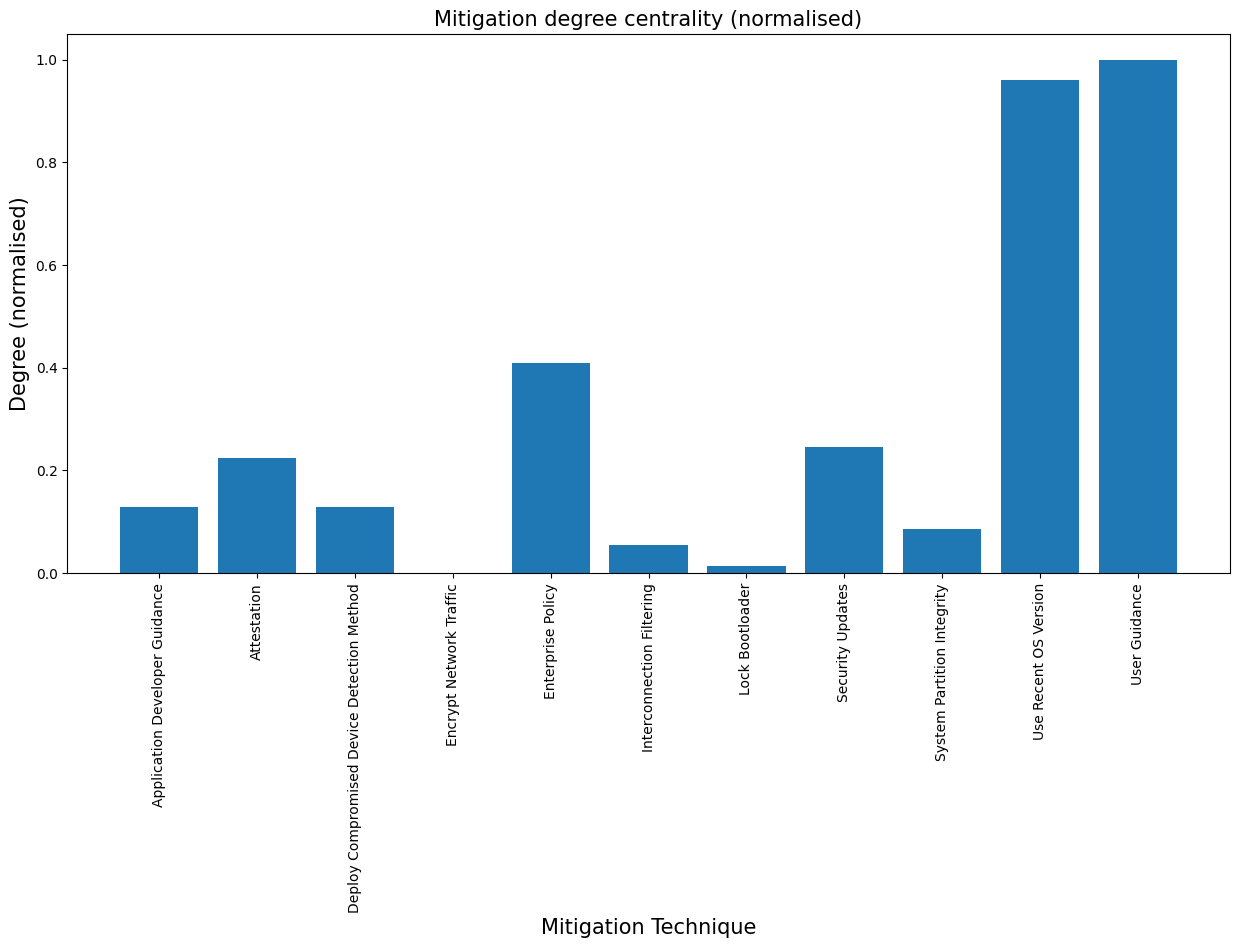

In [22]:
i=normalised_mit_degree.keys()
j=normalised_mit_degree.values()
print(normalised_mit_degree)
plt.figure(figsize=[15, 7])
plt.bar(i,j)

plt.title('Mitigation degree centrality (normalised)', fontsize=15)
plt.xlabel('Mitigation Technique', fontsize=15)
plt.ylabel('Degree (normalised)', fontsize=15)
plt.xticks(rotation=90)

plt.savefig('figs/degree_centrality/mitigations_degree_centrality_normalised.png', dpi=300, bbox_inches='tight')


plt.show()

In [16]:
thresholds = {'low': (0.0, 0.1), 'medium': (0.1, 0.7), 'high': (0.7, 1.0)}

def find_label(value, thresholds):
    for label, (min_val, max_val) in thresholds.items():
        if min_val <= value <= max_val:
            return label

categorised_items = {'low': [], 'medium': [], 'high': []}

for key, value in normalised_mit_degree.items():
    label = find_label(value, thresholds)
    categorised_items[label].append((key, value))

for label, items in categorised_items.items():
    print(f"{label.capitalize()}:")
    for item in items:
        print(f"  {item[0]}: {item[1]}")
    print()

Low:
  Encrypt Network Traffic: 0.0
  Interconnection Filtering: 0.05338078291814947
  Lock Bootloader: 0.014234875444839853
  System Partition Integrity: 0.08540925266903916

Medium:
  Application Developer Guidance: 0.1281138790035587
  Attestation: 0.22419928825622776
  Deploy Compromised Device Detection Method: 0.1281138790035587
  Enterprise Policy: 0.40925266903914587
  Security Updates: 0.24555160142348753

High:
  Use Recent OS Version: 0.9608540925266903
  User Guidance: 1.0



In [17]:
# Create a copy of the original dictionary
filtered_mitigations = mitigation_degree_centrality.copy()

# Remove 'Use Recent OS Version' and 'User Guidance' from the copied dictionary
del filtered_mitigations['Use Recent OS Version']
del filtered_mitigations['User Guidance']

# Normalize the data
min_value = min(filtered_mitigations.values())
max_value = max(filtered_mitigations.values())

normalised_filtered_degree = {
    key: (value - min_value) / (max_value - min_value)
    for key, value in filtered_mitigations.items()
}

print("-- Normalised mitigation degree centrality --")
for key, value in normalised_filtered_degree.items():
    print(f"{key}: {value}")


-- Normalised mitigation degree centrality --
Application Developer Guidance: 0.31304347826086953
Attestation: 0.5478260869565218
Deploy Compromised Device Detection Method: 0.31304347826086953
Encrypt Network Traffic: 0.0
Enterprise Policy: 1.0
Interconnection Filtering: 0.13043478260869568
Lock Bootloader: 0.03478260869565217
Security Updates: 0.6
System Partition Integrity: 0.2086956521739131


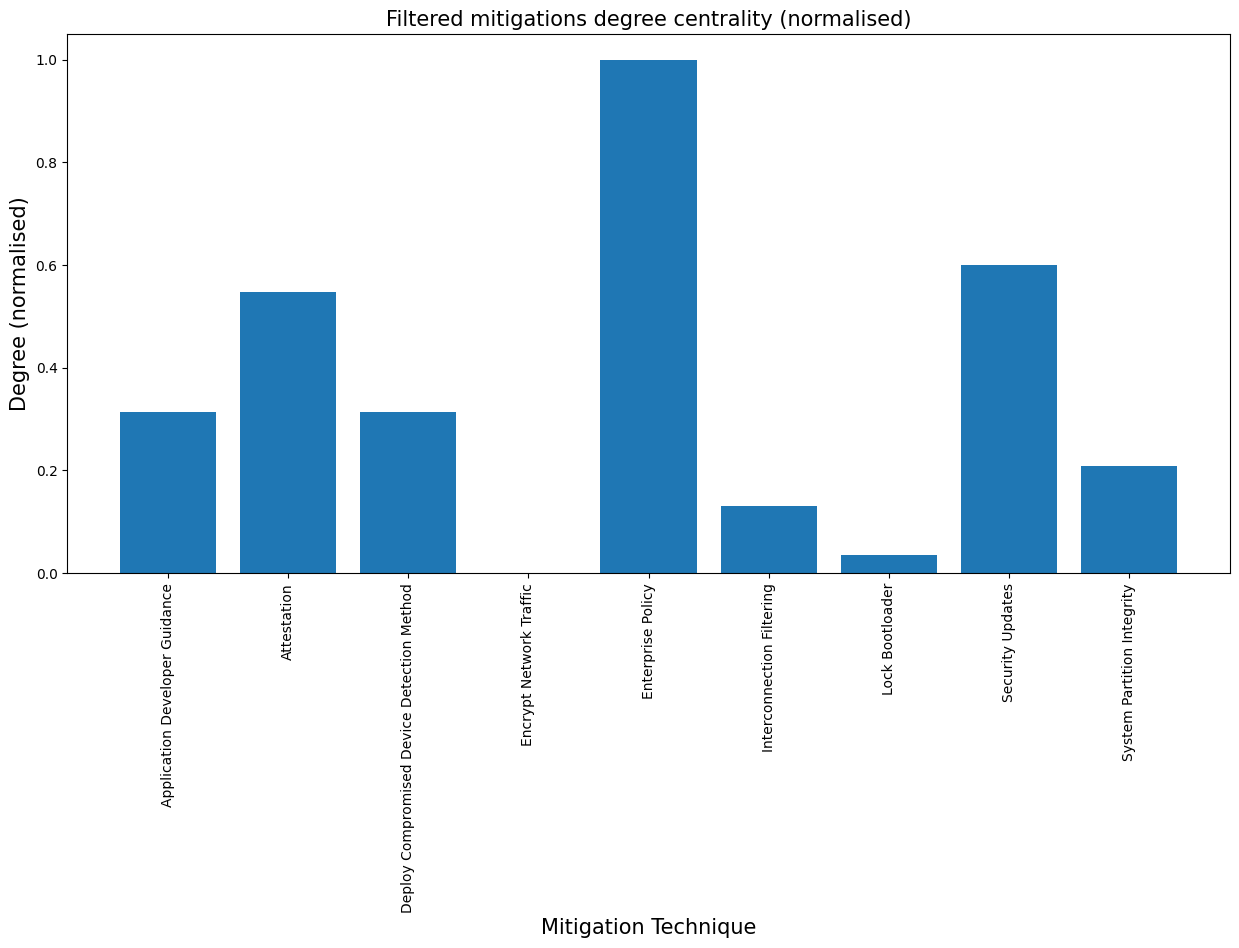

In [18]:
i=normalised_filtered_degree.keys()
j=normalised_filtered_degree.values()

plt.figure(figsize=[15, 7])
plt.bar(i,j)

plt.title('Filtered mitigations degree centrality (normalised)', fontsize=15)
plt.xlabel('Mitigation Technique', fontsize=15)
plt.ylabel('Degree (normalised)', fontsize=15)
plt.xticks(rotation=90)

plt.savefig('figs/degree_centrality/filtered_mitigations_degree_centrality_normalised.png', dpi=300, bbox_inches='tight')

plt.show()

In [19]:
thresholds = {'low': (0.0, 0.33), 'medium': (0.33, 0.66), 'high': (0.6, 1.0)}

def find_label(value, thresholds):
    for label, (min_val, max_val) in thresholds.items():
        if min_val <= value <= max_val:
            return label

categorised_items = {'low': [], 'medium': [], 'high': []}

for key, value in normalised_filtered_degree.items():
    label = find_label(value, thresholds)
    categorised_items[label].append((key, value))

for label, items in categorised_items.items():
    print(f"{label.capitalize()}:")
    for item in items:
        print(f"  {item[0]}: {item[1]}")
    print()

Low:
  Application Developer Guidance: 0.31304347826086953
  Deploy Compromised Device Detection Method: 0.31304347826086953
  Encrypt Network Traffic: 0.0
  Interconnection Filtering: 0.13043478260869568
  Lock Bootloader: 0.03478260869565217
  System Partition Integrity: 0.2086956521739131

Medium:
  Attestation: 0.5478260869565218
  Security Updates: 0.6

High:
  Enterprise Policy: 1.0



/tmp/ipykernel_70712/497195646.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


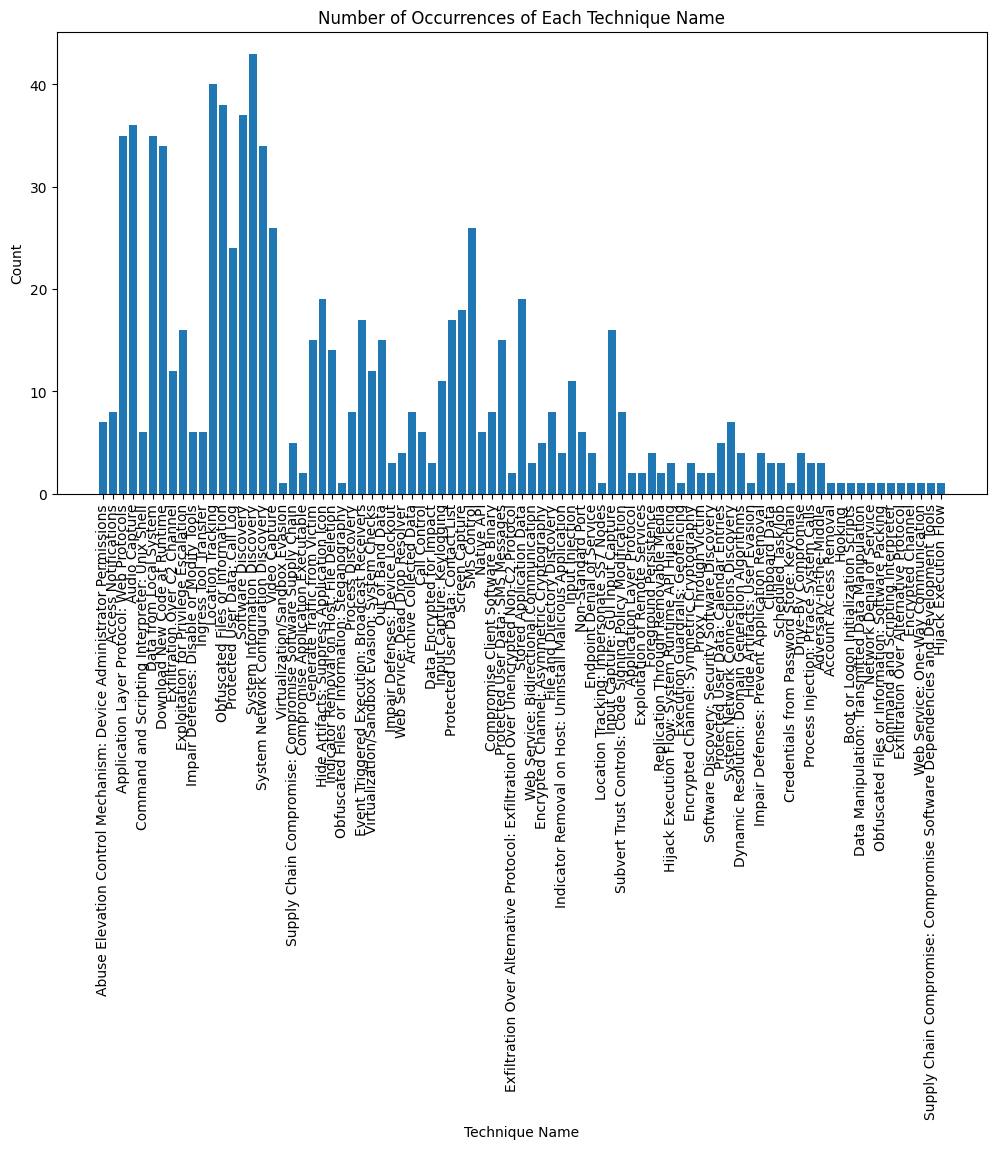

In [20]:
# Count the occurrences of each technique name
technique_counts = {}
for software in software_techniques:
    for technique in software['techniques']:
        technique_name = technique['technique_name']
        technique_counts[technique_name] = technique_counts.get(technique_name, 0) + 1

# Create the bar plot
technique_names = list(technique_counts.keys())
counts = list(technique_counts.values())

plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), counts)
plt.xticks(range(len(technique_names)), technique_names, rotation=90)
plt.xlabel('Technique Name')
plt.ylabel('Count')
plt.title('Number of Occurrences of Each Technique Name')
plt.tight_layout()
plt.show()
